# **Tutorial for cell-cell communication prediction for non-single-cell ST data with DeepTalk**
The notebook introduces to predicting cell-cell comunication using the DeepTalk method.

The notebook uses data from mouse brain cortex.

In [1]:
import sys
import os
import random
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage
import json
import seaborn as sns
import copy
from orderedset import OrderedSet
import DeepTalk_ST as dt
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# **Loading datasets**
Load public data available in Squidpy, from mouse brain cortex. 
Single cell data are stored in ```adata_sc```. Spatial data, in ```adata_st```..

In [2]:
adata_st = sq.datasets.visium_fluo_adata_crop()
adata_st = adata_st[
    adata_st.obs.cluster.isin([f"Cortex_{i}" for i in np.arange(1, 5)])
].copy()
img = sq.datasets.visium_fluo_image_crop()
adata_sc = sq.datasets.sc_mouse_cortex()

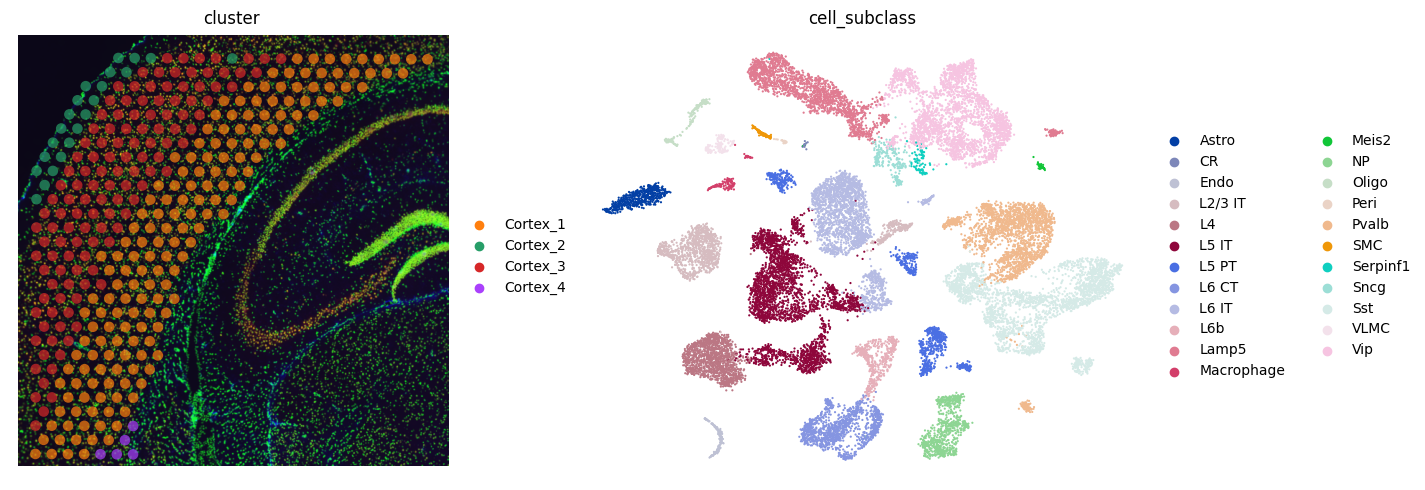

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sc.pl.spatial(
    adata_st, color="cluster", alpha=0.7, frameon=False, show=False, ax=axs[0]
)
sc.pl.umap(
    adata_sc, color="cell_subclass", size=10, frameon=False, show=False, ax=axs[1]
)
plt.tight_layout()

## **Pre-processing**

In [4]:
adata_sc_raw = copy.deepcopy(adata_sc)
sc.pp.normalize_total(adata_sc)
sc.pp.log1p(adata_sc)
adata_st_raw = copy.deepcopy(adata_st)
sc.pp.normalize_total(adata_st)
sc.pp.log1p(adata_st)

In order to deconvolve cells, **DeepTalk** needs to know how many cells are present in each voxel. This is achieved by segmenting the cells on the corresponding histology, which squidpy makes possible with two lines of code: ```squidpy.im.process``` applies smoothing as a pre-processing step. - ```squidpy.im.segment``` computes segmentation masks with watershed algorithm.

In [5]:
sq.im.process(img=img, layer="image", method="smooth")

sq.im.segment(
    img=img,
    layer="image_smooth",
    method="watershed",
    channel=0
)

Let’s visualize the segmentation results for an inset

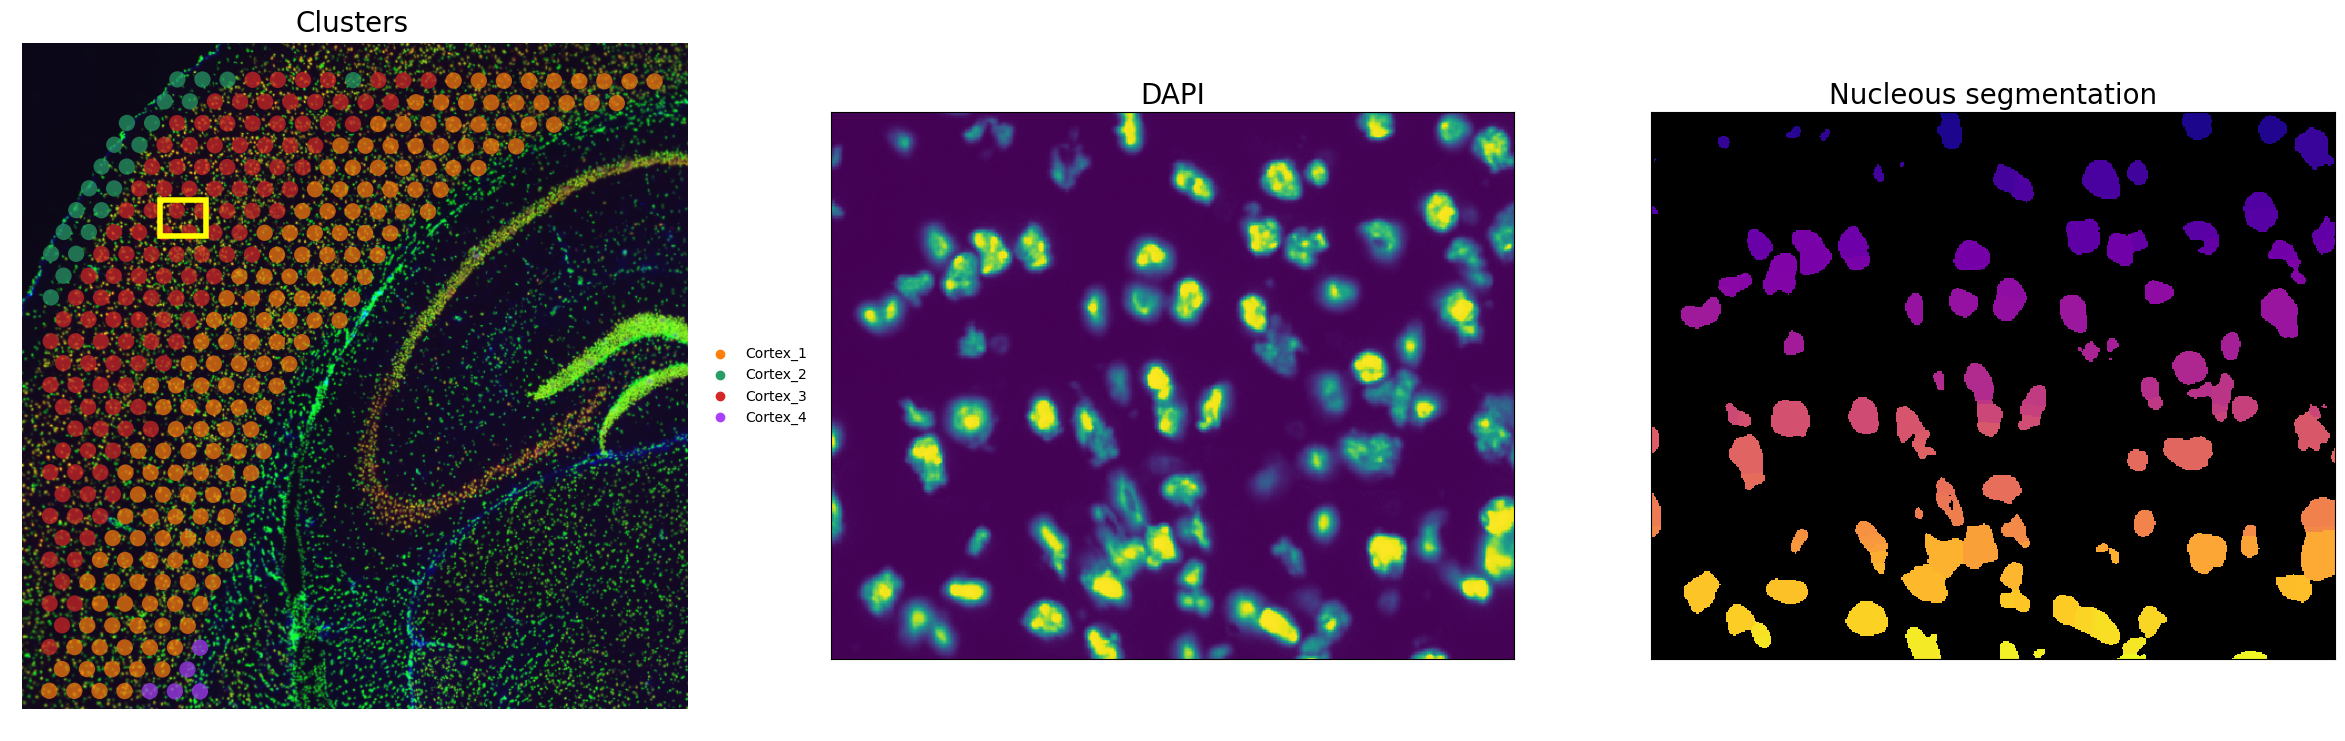

In [6]:
inset_y = 1500
inset_x = 1700
inset_sy = 400
inset_sx = 500

fig, axs = plt.subplots(1, 3, figsize=(30, 10))
sc.pl.spatial(
    adata_st, color="cluster", alpha=0.7, frameon=False, show=False, ax=axs[0], title=""
)
axs[0].set_title("Clusters", fontdict={"fontsize": 20})
sf = adata_st.uns["spatial"]["V1_Adult_Mouse_Brain_Coronal_Section_2"]["scalefactors"][
    "tissue_hires_scalef"
]
rect = mpl.patches.Rectangle(
    (inset_y * sf, inset_x * sf),
    width=inset_sx * sf,
    height=inset_sy * sf,
    ec="yellow",
    lw=4,
    fill=False,
)
axs[0].add_patch(rect)

axs[0].axes.xaxis.label.set_visible(False)
axs[0].axes.yaxis.label.set_visible(False)

axs[1].imshow(
    img["image"][inset_y : inset_y + inset_sy, inset_x : inset_x + inset_sx, 0, 0]
    / 65536,
    interpolation="none",
)
axs[1].grid(False)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("DAPI", fontdict={"fontsize": 20})

crop = img["segmented_watershed"][
    inset_y : inset_y + inset_sy, inset_x : inset_x + inset_sx
].values.squeeze(-1)
crop = skimage.segmentation.relabel_sequential(crop)[0]
cmap = plt.cm.plasma
cmap.set_under(color="black")
axs[2].imshow(crop, interpolation="none", cmap=cmap, vmin=0.001)
axs[2].grid(False)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title("Nucleous segmentation", fontdict={"fontsize": 20});

Comparison between DAPI and mask confirms the quality of the segmentation. We then need to extract some image features useful for the deconvolution task downstream. Specifically: - the number of unique segmentation objects (i.e. nuclei) under each spot. - the coordinates of the centroids of the segmentation object.

In [7]:
# define image layer to use for segmentation
features_kwargs = {
    "segmentation": {
        "label_layer": "segmented_watershed",
        "props": ["label", "centroid"],
        "channels": [1, 2],
    }
}

sq.im.calculate_image_features(
    adata_st,
    img,
    layer="image",
    key_added="image_features",
    features_kwargs=features_kwargs,
    features="segmentation",
    mask_circle=True,
)

  0%|          | 0/324 [00:00<?, ?/s]

In [8]:
adata_st.obsm['image_features']

segmentation_label  \
AAATGGCATGTCTTGT-1                  13   
AACAACTGGTAGTTGC-1                  15   
AACAGGAAATCGAATA-1                  28   
AACCCAGAGACGGAGA-1                   5   
AACCGTTGTGTTTGCT-1                   7   
...                                ...   
TTGGATTGGGTACCAC-1                  25   
TTGGCTCGCATGAGAC-1                   5   
TTGTATCACACAGAAT-1                  22   
TTGTGGCCCTGACAGT-1                  25   
TTGTTAGCAAATTCGA-1                  27   

                                                segmentation_centroid  
AAATGGCATGTCTTGT-1  [[5304.0, 731.0], [5320.947519118759, 721.3315...  
AACAACTGGTAGTTGC-1  [[1583.0, 4233.828793585227], [1671.5717336342...  
AACAGGAAATCGAATA-1  [[5028.0, 1061.4293230016444], [5042.200781827...  
AACCCAGAGACGGAGA-1  [[1185.0, 1012.0], [1257.9561167460154, 1023.3...  
AACCGTTGTGTTTGCT-1  [[4619.0, 381.72603026366806], [4627.707819057...  
...                                                               ...  
TTGGATTGGGTACCAC-1  [[3379.0, 1609.5027775295625], [3430.128033605...  
TTGGCTCGCATGAGAC-1  [[902.0, 3035.1389252487215], [913.41811041094...  
TTGTATCACACAGAAT-1  [[5992.0, 333.5593226506872], [6001.0050156143...  
TTGTGGCCCTGACAGT-1  [[4064.0, 1794.9633829463617], [4082.278586090...  
TTGTTAGCAAATTCGA-1  [[1589.0, 2787.4719677445705], [1597.800292086...  

[324 rows x 2 columns]

We can visualize the total number of objects under each spot with scanpy.


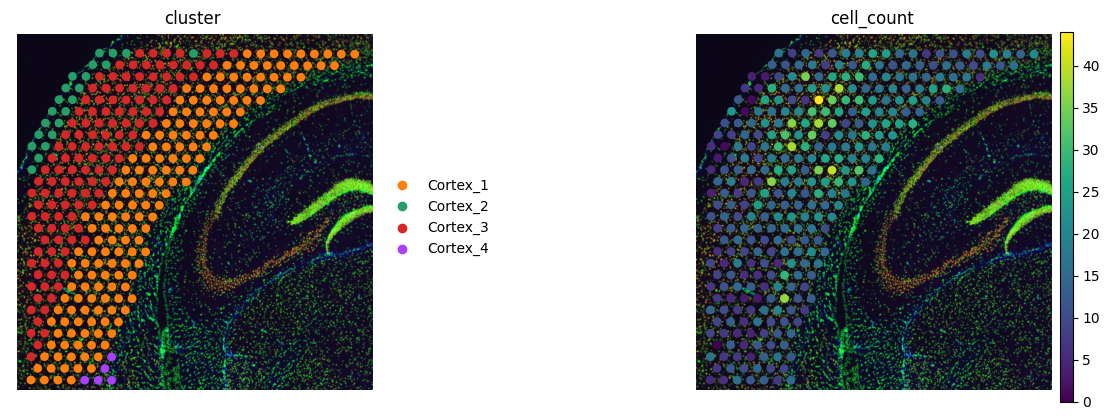

In [9]:
adata_st.obs["cell_count"] = adata_st.obsm["image_features"]["segmentation_label"]
sc.pl.spatial(adata_st, color=["cluster", "cell_count"], frameon=False)

For this case, we use 1291 marker genes as training genes.


In [10]:
sc.tl.rank_genes_groups(adata_sc, groupby="cell_subclass", use_raw=False)
markers_df = pd.DataFrame(adata_sc.uns["rank_genes_groups"]["names"]).iloc[0:100, :]
markers = list(np.unique(markers_df.melt().value.values))
len(markers)

1291

In [11]:
dt.pp_adatas(adata_sc, adata_st, genes=markers)

INFO:root:1187 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:14785 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


## **Deconvolution via DeepTalk**

In [12]:
ad_map = dt.map_cells_to_space(
    adata_sc=adata_sc,
    adata_sp=adata_st,
    learning_rate=0.0005,
    num_epochs=2000,
    #device='cpu', 
    device='cuda:0',
)

Start training
Epoch 100, Loss: -0.683,Score0: 0.683,Time: 0.995
Epoch 200, Loss: -0.686,Score0: 0.686,Time: 0.995
Epoch 300, Loss: -0.689,Score0: 0.689,Time: 0.997
Epoch 400, Loss: -0.692,Score0: 0.692,Time: 0.997
Epoch 500, Loss: -0.695,Score0: 0.695,Time: 1.003
Epoch 600, Loss: -0.697,Score0: 0.697,Time: 1.005
Epoch 700, Loss: -0.699,Score0: 0.699,Time: 1.008
Epoch 800, Loss: -0.700,Score0: 0.700,Time: 1.011
Epoch 900, Loss: -0.706,Score0: 0.706,Time: 1.013
Epoch 1000, Loss: -0.709,Score0: 0.709,Time: 1.007
Epoch 1100, Loss: -0.710,Score0: 0.710,Time: 1.016
Epoch 1200, Loss: -0.714,Score0: 0.714,Time: 1.016
Epoch 1300, Loss: -0.718,Score0: 0.718,Time: 1.011
Epoch 1400, Loss: -0.722,Score0: 0.722,Time: 1.011
Epoch 1500, Loss: -0.724,Score0: 0.724,Time: 1.014
Epoch 1600, Loss: -0.728,Score0: 0.728,Time: 1.015
Epoch 1700, Loss: -0.730,Score0: 0.730,Time: 1.007
Epoch 1800, Loss: -0.733,Score0: 0.733,Time: 1.012
Epoch 1900, Loss: -0.734,Score0: 0.734,Time: 1.014
Epoch 2000, Loss: -0.736,

In [13]:
import torch
torch.cuda.empty_cache()

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


<Figure size 640x480 with 0 Axes>

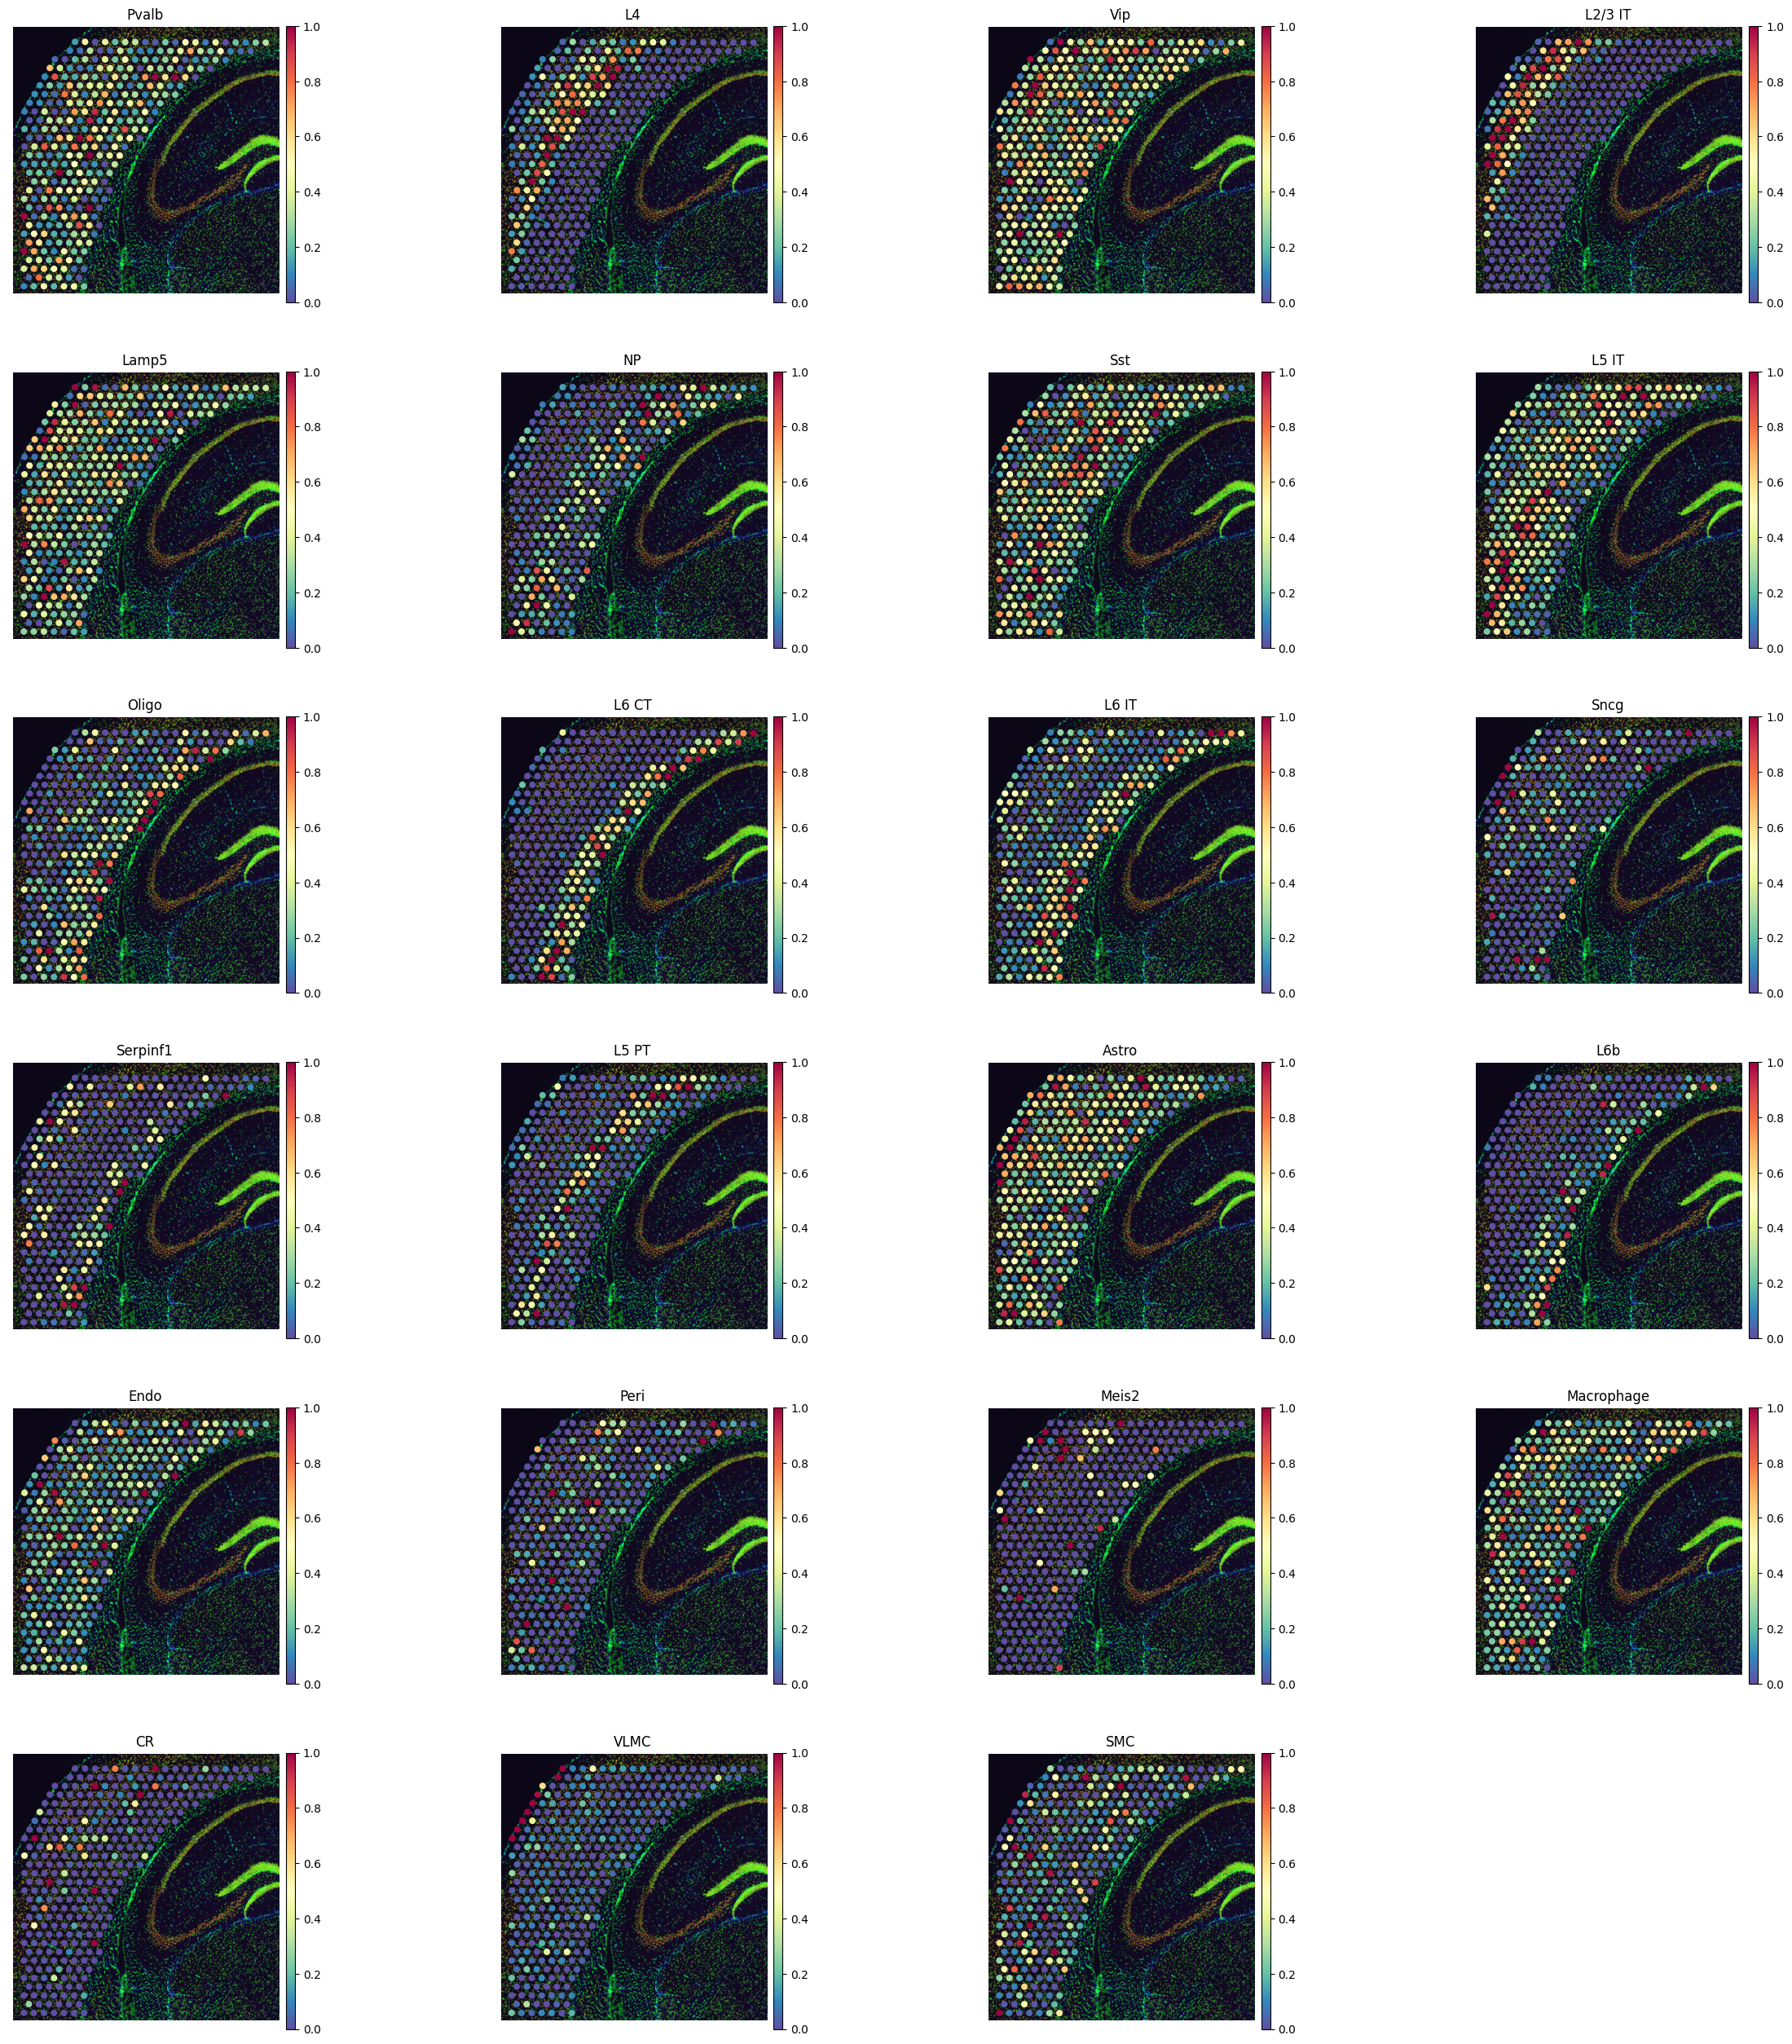

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
dt.project_cell_annotations(ad_map, adata_st, annotation="cell_subclass")
annotation_list = list(pd.unique(adata_sc.obs['cell_subclass']))
dt.plot_cell_annotation_sc1(adata_st, annotation_list,perc=0.02, cmap='Spectral_r', ncols=4,
                           scale_factor=adata_st.uns['spatial']['V1_Adult_Mouse_Brain_Coronal_Section_2']['scalefactors']['tissue_hires_scalef'])

In [15]:
ad_ge = dt.project_genes(adata_map=ad_map, adata_sc=adata_sc)
ad_ge

AnnData object with n_obs × n_vars = 324 × 36826
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster', 'cell_count', 'uniform_density', 'rna_count_based_density'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'sparsity', 'is_training'
    uns: 'cell_class_colors', 'cell_subclass_colors', 'hvg', 'neighbors', 'pca', 'umap', 'log1p', 'rank_genes_groups', 'training_genes', 'overlap_genes'

In [16]:
ad_ge.uns['spatial'] = adata_st.uns['spatial'].copy()
ad_ge.obsm['spatial'] = adata_st.obsm['spatial'].copy()

In [17]:
df_all_genes = dt.compare_spatial_geneexp(ad_ge, adata_st, adata_sc)
df_all_genes

score  is_training  sparsity_sp  sparsity_sc  sparsity_diff
atp1b1  9.954782e-01        False     0.000000     0.014334      -0.014334
snap25  9.954100e-01         True     0.000000     0.014610      -0.014610
ubb     9.953727e-01         True     0.000000     0.000092      -0.000092
hspa8   9.953697e-01         True     0.000000     0.000784      -0.000784
gapdh   9.953545e-01         True     0.000000     0.000968      -0.000968
...              ...          ...          ...          ...            ...
prr32   1.803760e-07        False     0.993827     0.999263      -0.005435
irx5    1.256196e-07        False     0.996914     0.999447      -0.002533
sntn    1.003194e-07        False     0.996914     0.999493      -0.002579
cckar   4.529484e-08        False     0.996914     0.999309      -0.002395
en2     3.466330e-08        False     0.996914     0.998848      -0.001934

[14785 rows x 5 columns]

In [18]:
dt.create_segment_cell_df(adata_st)
adata_st.uns["tangram_cell_segmentation"]

spot_idx            y            x              centroids
0     AAATGGCATGTCTTGT-1  5304.000000   731.000000   AAATGGCATGTCTTGT-1_0
1     AAATGGCATGTCTTGT-1  5320.947519   721.331554   AAATGGCATGTCTTGT-1_1
2     AAATGGCATGTCTTGT-1  5332.942342   717.447904   AAATGGCATGTCTTGT-1_2
3     AAATGGCATGTCTTGT-1  5349.584558   558.089490   AAATGGCATGTCTTGT-1_3
4     AAATGGCATGTCTTGT-1  5342.385687   566.886874   AAATGGCATGTCTTGT-1_4
...                  ...          ...          ...                    ...
5135  TTGTTAGCAAATTCGA-1  1736.336056  2800.001978  TTGTTAGCAAATTCGA-1_22
5136  TTGTTAGCAAATTCGA-1  1763.084642  2732.021185  TTGTTAGCAAATTCGA-1_23
5137  TTGTTAGCAAATTCGA-1  1761.129565  2722.866980  TTGTTAGCAAATTCGA-1_24
5138  TTGTTAGCAAATTCGA-1  1763.481302  2813.403047  TTGTTAGCAAATTCGA-1_25
5139  TTGTTAGCAAATTCGA-1  1768.000000  2777.945307  TTGTTAGCAAATTCGA-1_26

[5140 rows x 4 columns]

In [19]:
dt.count_cell_annotations(
    ad_map,
    adata_sc,
    adata_st,
    annotation="cell_subclass",
)
adata_st.obsm["tangram_ct_count"]

x     y  cell_n  \
AAATGGCATGTCTTGT-1   641  5393      13   
AACAACTGGTAGTTGC-1  4208  1672      15   
AACAGGAAATCGAATA-1  1117  5117      28   
AACCCAGAGACGGAGA-1  1101  1274       5   
AACCGTTGTGTTTGCT-1   399  4708       7   
...                  ...   ...     ...   
TTGGATTGGGTACCAC-1  1588  3468      25   
TTGGCTCGCATGAGAC-1  3011   991       5   
TTGTATCACACAGAAT-1   405  6081      22   
TTGTGGCCCTGACAGT-1  1830  4153      25   
TTGTTAGCAAATTCGA-1  2775  1678      27   

                                                            centroids  Pvalb  \
AAATGGCATGTCTTGT-1  [AAATGGCATGTCTTGT-1_0, AAATGGCATGTCTTGT-1_1, A...      2   
AACAACTGGTAGTTGC-1  [AACAACTGGTAGTTGC-1_0, AACAACTGGTAGTTGC-1_1, A...      2   
AACAGGAAATCGAATA-1  [AACAGGAAATCGAATA-1_0, AACAGGAAATCGAATA-1_1, A...      1   
AACCCAGAGACGGAGA-1  [AACCCAGAGACGGAGA-1_0, AACCCAGAGACGGAGA-1_1, A...      4   
AACCGTTGTGTTTGCT-1  [AACCGTTGTGTTTGCT-1_0, AACCGTTGTGTTTGCT-1_1, A...      7   
...                                                               ...    ...   
TTGGATTGGGTACCAC-1  [TTGGATTGGGTACCAC-1_0, TTGGATTGGGTACCAC-1_1, T...      3   
TTGGCTCGCATGAGAC-1  [TTGGCTCGCATGAGAC-1_0, TTGGCTCGCATGAGAC-1_1, T...      2   
TTGTATCACACAGAAT-1  [TTGTATCACACAGAAT-1_0, TTGTATCACACAGAAT-1_1, T...      1   
TTGTGGCCCTGACAGT-1  [TTGTGGCCCTGACAGT-1_0, TTGTGGCCCTGACAGT-1_1, T...      3   
TTGTTAGCAAATTCGA-1  [TTGTTAGCAAATTCGA-1_0, TTGTTAGCAAATTCGA-1_1, T...      0   

                    L4  Vip  L2/3 IT  Lamp5  NP  ...  L5 PT  Astro  L6b  Endo  \
AAATGGCATGTCTTGT-1   0    6        0      1   3  ...      3      1    0     0   
AACAACTGGTAGTTGC-1   0    7        1      4   2  ...      2      1    1     1   
AACAGGAAATCGAATA-1   0    3        0      2   0  ...      0      1    0     0   
AACCCAGAGACGGAGA-1   0    3        5      3   0  ...      0      2    0     1   
AACCGTTGTGTTTGCT-1   2    5        0      2   1  ...      2      0    1     1   
...                 ..  ...      ...    ...  ..  ...    ...    ...  ...   ...   
TTGGATTGGGTACCAC-1   1   10        0      1   1  ...      4      2    0     1   
TTGGCTCGCATGAGAC-1   1    2        5      2   0  ...      0      0    0     1   
TTGTATCACACAGAAT-1   0    1        0      3   1  ...      1      0    0     0   
TTGTGGCCCTGACAGT-1   0    3        0      0   0  ...      2      1    2     1   
TTGTTAGCAAATTCGA-1  12    1        0      2   0  ...      0      0    0     0   

                    Peri  Meis2  Macrophage  CR  VLMC  SMC  
AAATGGCATGTCTTGT-1     0      0           1   0     0    0  
AACAACTGGTAGTTGC-1     0      0           1   0     0    0  
AACAGGAAATCGAATA-1     0      0           1   0     0    0  
AACCCAGAGACGGAGA-1     0      0           1   0     1    0  
AACCGTTGTGTTTGCT-1     0      0           0   0     0    0  
...                  ...    ...         ...  ..   ...  ...  
TTGGATTGGGTACCAC-1     0      0           0   0     0    1  
TTGGCTCGCATGAGAC-1     0      0           1   0     0    0  
TTGTATCACACAGAAT-1     0      0           0   0     0    0  
TTGTGGCCCTGACAGT-1     0      0           0   0     0    0  
TTGTTAGCAAATTCGA-1     1      0           0   0     0    0  

[324 rows x 27 columns]

In [20]:
adata_segment = dt.deconvolve_cell_annotations(adata_st)
adata_segment.obs

y            x              centroids cluster
0     5304.000000   731.000000   AAATGGCATGTCTTGT-1_0   Pvalb
1     5320.947519   721.331554   AAATGGCATGTCTTGT-1_1   Pvalb
2     5332.942342   717.447904   AAATGGCATGTCTTGT-1_2     Vip
3     5349.584558   558.089490   AAATGGCATGTCTTGT-1_3     Vip
4     5342.385687   566.886874   AAATGGCATGTCTTGT-1_4     Vip
...           ...          ...                    ...     ...
5039  1736.336056  2800.001978  TTGTTAGCAAATTCGA-1_22   L5 IT
5040  1763.084642  2732.021185  TTGTTAGCAAATTCGA-1_23   L5 IT
5041  1761.129565  2722.866980  TTGTTAGCAAATTCGA-1_24   L5 IT
5042  1763.481302  2813.403047  TTGTTAGCAAATTCGA-1_25   L5 IT
5043  1768.000000  2777.945307  TTGTTAGCAAATTCGA-1_26   L5 IT

[5044 rows x 4 columns]

In [21]:
mapping_colors = {
    "L6 CT": (0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
    "L6 IT": (0.4196078431372549, 0.6823529411764706, 0.8392156862745098),
    "NP": (0.6196078431372549, 0.792156862745098, 0.8823529411764706),
    "L6b": "#0000c2ff",
    "L2/3 IT": "#a1ed7bff",
    "L5 IT": (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
    "L5 ET": (0.4549019607843137, 0.7686274509803922, 0.4627450980392157),
    "Oligo": (0.4588235294117647, 0.4196078431372549, 0.6941176470588235),
    "Vip": (0.6196078431372549, 0.6039215686274509, 0.7843137254901961),
    "Astro": "#ffdd55ff",
    "L6 CT": "#000000ff",
    "Pvalb": (0.38823529411764707, 0.38823529411764707, 0.38823529411764707),
    "Lamp5": (0.5882352941176471, 0.5882352941176471, 0.5882352941176471),
    "Sst": (0.7411764705882353, 0.7411764705882353, 0.7411764705882353),
    "CR": (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
    "Sncg": (0.5176470588235295, 0.23529411764705882, 0.2235294117647059),
    "Peri": (0.6784313725490196, 0.28627450980392155, 0.2901960784313726),
    "VLMC": (0.8392156862745098, 0.3803921568627451, 0.4196078431372549),
    "Endo": (0.9058823529411765, 0.5882352941176471, 0.611764705882353),
    "Meis2": "#FFA500ff",
    "SMC": "#000000ff",
    "L6 PT": "#4682B4ff",
    "L5 PT": (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
    "L5 NP": "#6B8E23ff",
    "L4": "#d61f1dff",
    "Macrophage": "#2b2d2fff",
    "Serpinf1": "#000000ff",
}

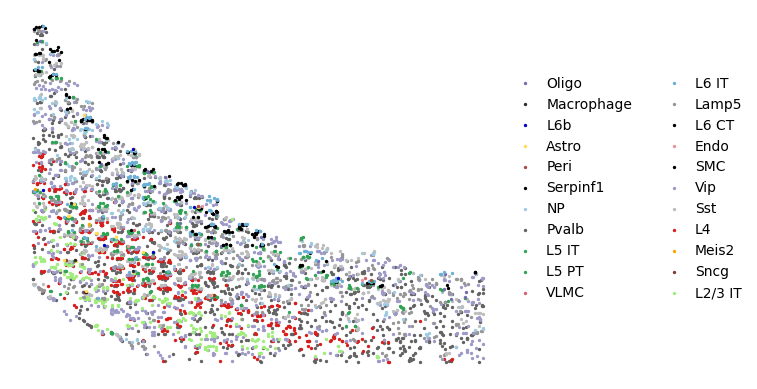

In [22]:

cluster = adata_segment.obs['cluster'].values
dt.plot_cell_type_ST(adata_segment,mapping_colors,cluster)

In [23]:
Test_dir = './test/spot/'
isExists = os.path.exists(Test_dir)
if isExists:
    pass
else:
    os.makedirs(Test_dir)

In [24]:
adata_segment.obs.to_csv(Test_dir + '/st_obs.csv')
adata_sc.obs.to_csv(Test_dir + '/sc_obs.csv')

In [25]:
index1 = [word.capitalize() for word in adata_sc.var.index]
c_list = [f'C{i}' for i in range(1, adata_sc.X.shape[0]+1)]
df = pd.DataFrame(adata_sc.X.T,index=index1,columns=c_list)
df.to_csv(Test_dir + '/ad_sc.csv')

In [26]:
index1 = [word.capitalize() for word in ad_ge.var.index]
c_list = [word.capitalize() for word in ad_ge.obs.index]
df = pd.DataFrame(ad_ge.X.T,index=index1,columns=c_list)
df.to_csv(Test_dir + '/ad_ge.csv')

In [27]:
dt.New_ST_data_pre(data_name = Test_dir + '/ad_st_new.csv', outdir =  './test/spot/')

In [28]:
dt.File_Train_ST(data_name = Test_dir + '/ad_st_new.csv', LR_train = 'Mif_Epha5',
	outdir =  Test_dir)

staring


In [29]:
dt.Cell_Label_Define(data_name = Test_dir + '/ad_st_new.csv',ligand = 'Mif', receptor = 'Epha5',
           cell_pair = Test_dir + '/cell_pair_all.csv', outdir = Test_dir)

staring


In [30]:
dt.CCC_LR_pre(data_name = Test_dir + '/ad_st_new.csv',ligand = 'Sema3c', receptor = 'Fzd3',
           cell_pair = Test_dir + '/cell_pair_all.csv', outdir = Test_dir)

staring


**Generate training data and prediction data.**

In [31]:
dt.data_for_train(data_dir = Test_dir +'/data/', data_name = Test_dir + '/ad_st_new.csv', 
	LR_train = 'Mif_Epha5')

In [32]:
dt.data_for_test(data_dir = Test_dir +'/data/', data_name = Test_dir + '/ad_st_new.csv', 
	LR_test = 'Sema3c_Fzd3')

## **Prediction of spatial CCC at the single-cell resolution.**
Train the data using subgraph-based GAT and generate a prediction model.

The training process may take some time.

The trained model can be used to predict intercellular communication mediated by other L-R interactions

In [33]:
dt.Train(data_name = 'Mif_Epha5',data_path = Test_dir + '/data/',
    outdir = Test_dir + '/data/Mif_Epha5/output',
    pretrained_embeddings = Test_dir + '/data/Mif_Epha5/data_pca.emd',
    n_epochs = 50,ft_n_epochs=10)


 Loading graph...
DataSet Stats :
Number of Nodes 5067
Number of Edges 61931
Number of Node types 1
Number of relations 1
Graph with 5067 nodes and 61931 edges
5067 2
check torch.Size([5067, 128]) 5044
node2vec tensor torch.Size([5067, 128])
No. of nodes with pretrained embedding:  5067
No. edges in test data:  23087
***************PRETRAINING***************

 generate walks ...
no. of walks 40536
train ./test/spot//data//Mif_Epha5/outdir/Mif_Epha5_walks_train.txt
validate ./test/spot//data//Mif_Epha5/outdir/Mif_Epha5_walks_validate.txt
test ./test/spot//data//Mif_Epha5/outdir/Mif_Epha5_walks_test.txt

 Run model for pre-training ...

 Begin Training

Epoch: 0
MinLoss: 1000000.0, CurLoss: 8.6461
epoch time: (s) 72.45110249519348
epoch time: (s) 69.4334933757782
epoch time: (s) 70.03770852088928
epoch time: (s) 69.17976665496826
epoch time: (s) 69.12182760238647
epoch time: (s) 69.16605830192566
epoch time: (s) 69.83920574188232
epoch time: (s) 68.7030599117279
epoch time: (s) 69.52521

**Predicting cell-cell communication mediated by ```Sema3c_Fzd3```.**

In [34]:
dt.run_predict(data_name='Sema3c_Fzd3',data_path = Test_dir +'/data/',
    outdir = Test_dir +'/data/Sema3c_Fzd3/output',
    pretrained_embeddings = Test_dir +'/data/Sema3c_Fzd3/data_pca_test.emd',model_path = Test_dir+'/data/Mif_Epha5/output/finetune/results')

DataSet Stats :
Number of Nodes 4407
Number of Edges 31098
Number of Node types 1
Number of relations 1
check torch.Size([4407, 128]) 3887
node2vec tensor torch.Size([4407, 128])
4 4 Linear(in_features=512, out_features=512, bias=True)
Begin Predicting
Done


## **Visualize of the spatial CCC**

In [35]:
mapping_colors = {
    "L6_CT": (0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
    "L6_IT": (0.4196078431372549, 0.6823529411764706, 0.8392156862745098),
    "NP": (0.6196078431372549, 0.792156862745098, 0.8823529411764706),
    "L6b": "#0000c2ff",
    "L2/3_IT": "#a1ed7bff",
    "L5_IT": (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
    "L5_ET": (0.4549019607843137, 0.7686274509803922, 0.4627450980392157),
    "Oligo": (0.4588235294117647, 0.4196078431372549, 0.6941176470588235),
    "Vip": (0.6196078431372549, 0.6039215686274509, 0.7843137254901961),
    "Astro": "#ffdd55ff",
    "L6_CT": "#000000ff",
    "Pvalb": (0.38823529411764707, 0.38823529411764707, 0.38823529411764707),
    "Lamp5": (0.5882352941176471, 0.5882352941176471, 0.5882352941176471),
    "Sst": (0.7411764705882353, 0.7411764705882353, 0.7411764705882353),
    "Sst Chodl": (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
    "Sncg": (0.5176470588235295, 0.23529411764705882, 0.2235294117647059),
    "Peri": (0.6784313725490196, 0.28627450980392155, 0.2901960784313726),
    "VLMC": (0.8392156862745098, 0.3803921568627451, 0.4196078431372549),
    "Endo": (0.9058823529411765, 0.5882352941176471, 0.611764705882353),
    "Meis2": "#FFA500ff",
    "SMC": "#000000ff",
    "L6_PT": "#4682B4ff",
    "L5_PT": (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
    "L5_NP": "#6B8E23ff",
    "L4": "#d61f1dff",
    "Macrophage": "#2b2d2fff",
    "Serpinf1": "#000000ff",
}

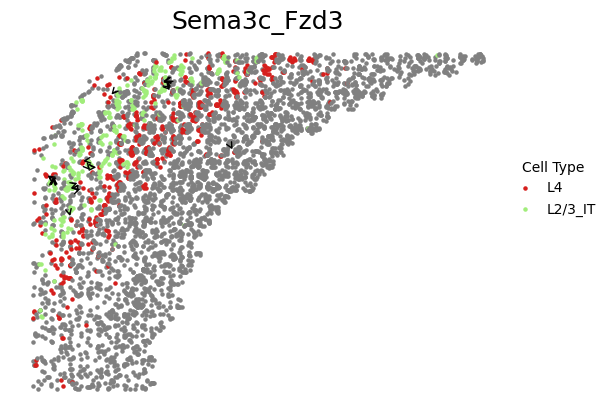

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
dt.plot_CCC_N_ST(mapping_colors, data_name = Test_dir + '/ad_st_new.csv',meta_data = Test_dir +'st_meta.csv',ligand = 'Sema3c',
    receptor = 'Fzd3',CCC_label = Test_dir + '/data/Sema3c_Fzd3/predict_ccc.txt',
    sourcetype = 'L2/3_IT',targettype = 'L4',top_score = 50)

['Oligo', 'Macrophage', 'L6b', 'Astro', 'L2/3_IT', 'Peri', 'NP', 'L5_IT', 'Pvalb', 'VLMC', 'Lamp5', 'L5_PT', 'Endo', 'Vip', 'Sst', 'L4', 'Meis2', 'Sncg', 'L6_IT', 'L6_CT']


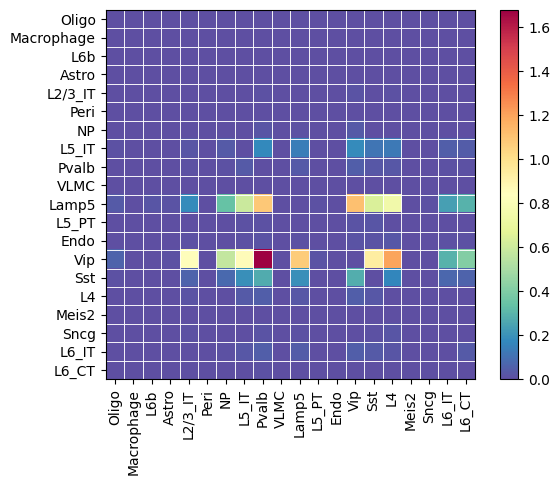

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
dt.plot_CCC_heatmap_ST(meta_data =  Test_dir +'st_meta.csv',data_name =  Test_dir +'ad_st_new.csv',
                    ligand = 'Sema3c', receptor = 'Fzd3', CCC_label = Test_dir +'/data/Sema3c_Fzd3/predict_ccc.txt')